In [1]:
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle

In [2]:
# base_dir = 'results/flow_cdf'
# dirs = os.listdir(base_dir)
# dirs = [d for d in dirs if d!='aus']
# res_df_list = [pd.read_csv(os.path.join(base_dir, d, 'results.csv')).drop(columns=['Unnamed: 0']) for d in dirs]
# res_df = pd.concat(res_df_list)
# res_df.station_id = res_df.station_id.apply(lambda x: x[2:-1])
# res_df = res_df.set_index('station_id', drop=True)
# res_df.mean()

In [3]:
base_dir = 'results/flow_cdf_cnn'
dirs = os.listdir(base_dir)
dirs = [d for d in dirs if d!='aus' and not d.endswith('.png')]

aggs_dikt = {
    'zone': 'count',
    'train_mse': 'mean',
    'test_mse': 'mean',
    'train_r2': 'mean',
    'test_r2': 'mean'
}

scalers = {}

cdf_res_df_list = []
for d in dirs:
    df = pd.read_csv(os.path.join(base_dir, d, 'results.csv')).drop(columns=['Unnamed: 0'])
    state, zone = d.split('_')
    df['state'] = state
    df['zone'] = int(zone)
    # df.station_id = df.station_id.apply(lambda x: x[2:-1])
    df.set_index('station_id', drop=True, inplace=True)
    cdf_res_df_list.append(df)

    with open(os.path.join(base_dir, d, 'scalers.pkl'), 'rb') as fil:
        scalers[d] = pickle.load(fil)

cdf_res_df = pd.concat(cdf_res_df_list)
cdf_perf_df = cdf_res_df.groupby(['state']).agg(aggs_dikt).sort_values(by='test_mse')
cdf_perf_df = cdf_perf_df.rename(columns={'zone': 'station_count'})
cdf_perf_df

,station_count,train_mse,test_mse,train_r2,test_r2
state,,,,,
TAS,12,0.015954,0.017407,0.807381,0.794966
WA,16,0.020130,0.034638,0.762465,0.477148
ACT,3,0.022527,0.036275,0.730990,0.550968
VIC,72,0.024969,0.039703,0.700197,0.434680
NSW,33,0.037082,0.042965,0.557506,0.444883
QLD,61,0.038239,0.046336,0.541748,0.292188
NT,16,0.038216,0.048754,0.558492,-0.130242
SA,9,0.032740,0.049900,0.592578,0.359566


In [4]:
print(cdf_perf_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  station\_count &  train\_mse &  test\_mse &  train\_r2 &   test\_r2 \\
state &                &            &           &           &           \\
\midrule
TAS   &             12 &   0.015954 &  0.017407 &  0.807381 &  0.794966 \\
WA    &             16 &   0.020130 &  0.034638 &  0.762465 &  0.477148 \\
ACT   &              3 &   0.022527 &  0.036275 &  0.730990 &  0.550968 \\
VIC   &             72 &   0.024969 &  0.039703 &  0.700197 &  0.434680 \\
NSW   &             33 &   0.037082 &  0.042965 &  0.557506 &  0.444883 \\
QLD   &             61 &   0.038239 &  0.046336 &  0.541748 &  0.292188 \\
NT    &             16 &   0.038216 &  0.048754 &  0.558492 & -0.130242 \\
SA    &              9 &   0.032740 &  0.049900 &  0.592578 &  0.359566 \\
\bottomrule
\end{tabular}



/scratch/pbs.5815334.kman.restech.unsw.edu.au/ipykernel_1909844/1729900787.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cdf_perf_df.to_latex())


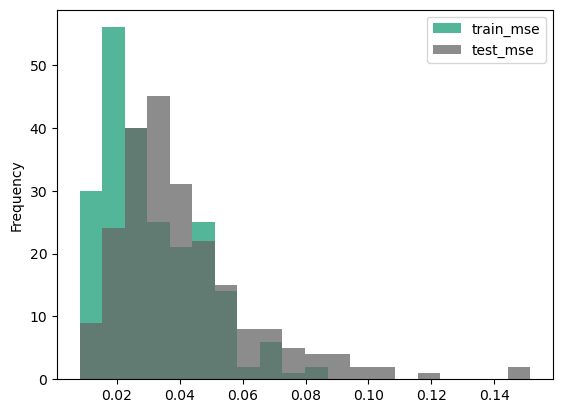

In [5]:
fig, ax = plt.subplots()
cdf_res_df[['train_mse', 'test_mse']].plot.hist(bins=20, alpha=0.75, ax=ax, colormap='Dark2')
fig.savefig(os.path.join(base_dir, 'hist.png'))

In [17]:
aggs_dikt = {
    'zone': 'nunique',
    # 'train_mse': 'mean',
    # 'test_mse': 'mean',
    'train_r2': 'mean',
    'test_r2': 'mean',
    'train_mse': 'count'
}

models = ['mlp', 'cnn', 'rnn', 'lstm']
cdf_perf_df_list = []

for model in models:

    base_dir = f'results/flow_cdf_{model}'
    dirs = os.listdir(base_dir)
    dirs = [d for d in dirs if d!='aus' and not d.endswith('.png')]

    cdf_res_df_list = []
    for d in dirs:
        df = pd.read_csv(os.path.join(base_dir, d, 'results.csv')).drop(columns=['Unnamed: 0'])
        state, zone = d.split('_')
        df['state'] = state
        df['zone'] = int(zone)
        df['ts_model'] = model
        df.set_index('station_id', drop=True, inplace=True)
        cdf_res_df_list.append(df)
    
    cdf_res_df = pd.concat(cdf_res_df_list)
    cdf_perf_df = cdf_res_df.groupby(['state', 'zone']).agg(aggs_dikt)
    cdf_perf_df = cdf_perf_df.rename(columns={'zone': 'zones', 'train_mse': 'stations'}).drop(columns=['zones'])
    cdf_perf_df = cdf_perf_df.sort_values(['state', 'zone']).reset_index()
    cdf_perf_df = cdf_perf_df.set_index(['state', 'zone', 'stations'])
    new_level = [model for col in cdf_perf_df.columns]
    cdf_perf_df.columns = pd.MultiIndex.from_tuples(zip(new_level, cdf_perf_df.columns))
    cdf_perf_df_list.append(cdf_perf_df)

cdf_perf_df = pd.concat(cdf_perf_df_list, axis=1)
cdf_perf_df

mlp              cnn              rnn          \
                    train_r2 test_r2 train_r2 test_r2 train_r2 test_r2   
state zone stations                                                      
ACT   55   3          0.7051  0.5530   0.7310  0.5510   0.7359  0.5566   
NSW   55   15         0.5691  0.4159   0.6148  0.4662   0.6420  0.4447   
      56   18         0.4581  0.3705   0.5098  0.4271   0.5293  0.4201   
NT    52   6          0.6642 -0.0154   0.6613 -0.3955   0.7021 -0.2634   
      53   10         0.4757  0.0625   0.4968  0.0289   0.5020  0.0002   
QLD   54   8          0.5836  0.4366   0.6310  0.5678   0.6837  0.5756   
      55   25         0.5960  0.3695   0.6447  0.3675   0.6680  0.3490   
      56   28         0.3931  0.0132   0.4243  0.1462   0.4819  0.0295   
SA    53   1          0.7771  0.7582   0.7952  0.7982   0.8076  0.8010   
      54   8          0.5604  0.3229   0.5673  0.3047   0.5972  0.3230   
TAS   55   12         0.7504  0.7355   0.8074  0.7950   0.8287  0.7976   
VIC   54   10         0.5191 -0.3233   0.5354 -0.3358   0.5640 -0.4470   
      55   62         0.6604  0.5174   0.7268  0.5589   0.7605  0.5420   
WA    50   13         0.7678  0.5185   0.7951  0.4751   0.8005  0.4756   
      51   2          0.6906  0.5152   0.6852  0.5123   0.6999  0.4062   
      52   1          0.4823  0.4559   0.4930  0.4330   0.5025  0.4843   

                        lstm          
                    train_r2 test_r2  
state zone stations                   
ACT   55   3          0.7485  0.5721  
NSW   55   15         0.6533  0.4816  
      56   18         0.5505  0.4282  
NT    52   6          0.6586 -0.2196  
      53   10         0.4865  0.0336  
QLD   54   8          0.6604  0.6042  
      55   25         0.6645  0.3887  
      56   28         0.4266  0.1613  
SA    53   1          0.7999  0.8072  
      54   8          0.5719  0.3233  
TAS   55   12         0.8629  0.8059  
VIC   54   10         0.5287 -0.3837  
      55   62         0.7720  0.5636  
WA    50   13         0.7884  0.4810  
      51   2          0.7022  0.5264  
      52   1          0.4941  0.4906

In [18]:
pd.set_option("display.precision", 4)
print(cdf_perf_df.to_latex())

\begin{tabular}{lllrrrrrrrr}
\toprule
   &    &    & \multicolumn{2}{l}{mlp} & \multicolumn{2}{l}{cnn} & \multicolumn{2}{l}{rnn} & \multicolumn{2}{l}{lstm} \\
   &    &    & train\_r2 & test\_r2 & train\_r2 & test\_r2 & train\_r2 & test\_r2 & train\_r2 & test\_r2 \\
state & zone & stations &          &         &          &         &          &         &          &         \\
\midrule
ACT & 55 & 3  &   0.7051 &  0.5530 &   0.7310 &  0.5510 &   0.7359 &  0.5566 &   0.7485 &  0.5721 \\
NSW & 55 & 15 &   0.5691 &  0.4159 &   0.6148 &  0.4662 &   0.6420 &  0.4447 &   0.6533 &  0.4816 \\
   & 56 & 18 &   0.4581 &  0.3705 &   0.5098 &  0.4271 &   0.5293 &  0.4201 &   0.5505 &  0.4282 \\
NT & 52 & 6  &   0.6642 & -0.0154 &   0.6613 & -0.3955 &   0.7021 & -0.2634 &   0.6586 & -0.2196 \\
   & 53 & 10 &   0.4757 &  0.0625 &   0.4968 &  0.0289 &   0.5020 &  0.0002 &   0.4865 &  0.0336 \\
QLD & 54 & 8  &   0.5836 &  0.4366 &   0.6310 &  0.5678 &   0.6837 &  0.5756 &   0.6604 &  0.6042 \\
   & 55 & 

/scratch/pbs.5815334.kman.restech.unsw.edu.au/ipykernel_1909844/3700187585.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cdf_perf_df.to_latex())


In [2]:
from data.tf.camels_dataset import CamelsDataset

2024-10-17 12:00:12.614872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 12:00:13.468590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 12:00:13.794946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 12:00:13.831035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 12:00:14.035725: I tensorflow/core/platform/cpu_feature_guar

In [3]:
camels_dir = '../data/camels/aus'
camels_ds = CamelsDataset(data_dir=camels_dir)

In [4]:
station_list = camels_ds.get_station_list()
print(np.random.permutation(station_list)[:10].tolist())

['113004A', '227227', '919003A', 'G9030124', '121001A', '407253', 'A5030502', '143303A', '608002', '405248']


In [9]:
loc_df = camels_ds.repo.data[['lat_outlet', 'long_outlet']].to_dataframe()
station_df = pd.concat([cdf_res_df, loc_df], axis=1)
station_df['zone_id'] = station_df.apply(lambda x: f"{x['state']}_{x['zone']}", axis=1)
station_df = station_df.sort_values(by='zone_id')
station_df.head()

,train_mse,test_mse,state,zone,lat_outlet,long_outlet,zone_id
station_id,,,,,,,
410730,0.018229,0.029168,ACT,55,-35.591944,148.822222,ACT_55
410731,0.019701,0.041623,ACT,55,-35.575000,149.066111,ACT_55
410761,0.021961,0.033892,ACT,55,-35.540000,149.101944,ACT_55
401015,0.043600,0.041336,NSW,55,-35.916667,146.976944,NSW_55
401012,0.016833,0.028372,NSW,55,-36.318333,148.051944,NSW_55


In [10]:
station_df.zone_id.nunique()

16

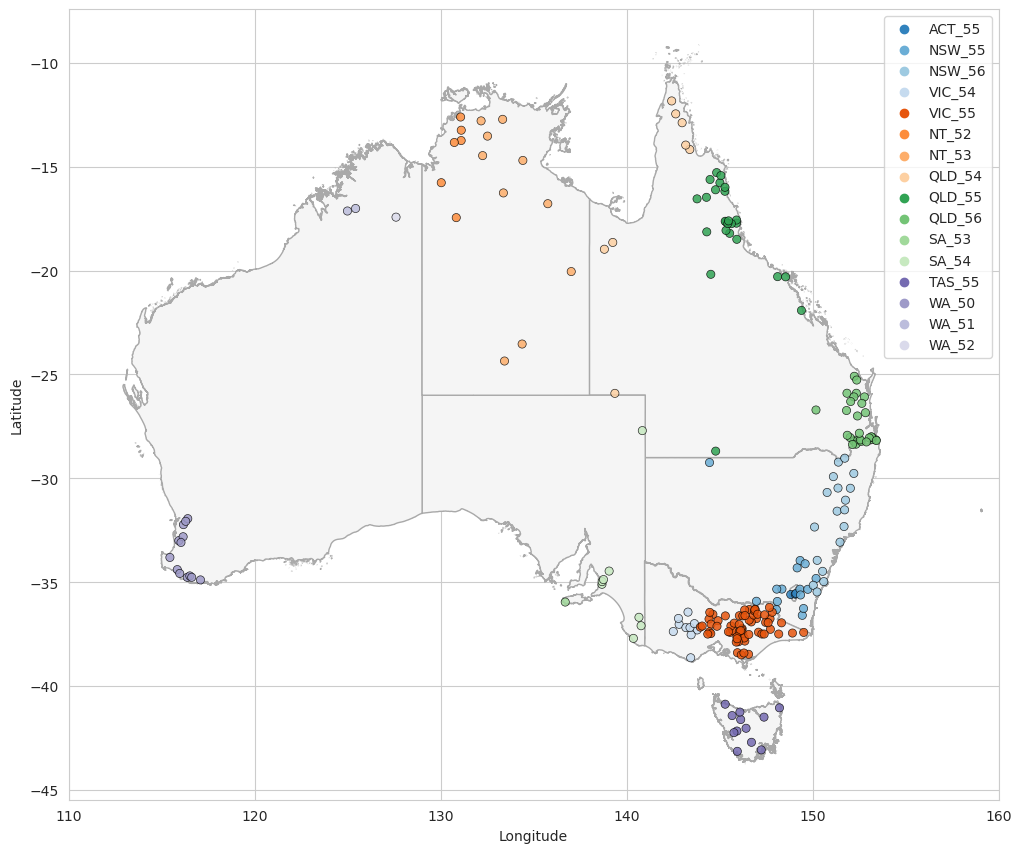

In [31]:
# Load the shapefile of Australia
australia = gpd.read_file('../data/camels/aus/02_location_boundary_area/shp/bonus data/Australia_boundaries.shp')#'../data/camels/aus/shp/AUS_2021_AUST_GDA2020.shp')

# Define the CRS of the shapefile manually
australia.crs = 'epsg:7844'

# Create a GeoDataFrame from the DataFrame of cities
gdf_cities = gpd.GeoDataFrame(station_df, geometry=gpd.points_from_xy(station_df.long_outlet, station_df.lat_outlet))

# Set the CRS of the GeoDataFrame to EPSG 7844
# https://epsg.io/7844
gdf_cities.crs = 'epsg:7844'

# Reproject the GeoDataFrame of cities to match the CRS of the shapefile
gdf_cities = gdf_cities.to_crs(australia.crs)

# Perform a spatial join to link the cities to their corresponding polygons in the shapefile
gdf_cities = gpd.sjoin(gdf_cities, australia, predicate='within')

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))

# Define a custom dark color palette
custom_palette = sns.color_palette(['darkblue', 'black', 'purple','darkred',
                                    'darkgreen', 'darkorange', 'brown' , 'blue'], 
                                   n_colors=len(station_df['zone_id'].unique()))

# # Plot the cities colored by priority with adjustments
sns.scatterplot(ax=ax, data=gdf_cities, x='long_outlet', y='lat_outlet',
                hue='zone_id', palette='tab20c', s=35, 
                edgecolor='black', alpha=0.85, legend=True, zorder=2)

# norm = plt.Normalize(gdf_cities['test_mse'].min(), gdf_cities['test_mse'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# Add a colorbar
# ax.figure.colorbar(sm,fraction=0.046, pad=0.04)

# Set x-axis limits
ax.set_xlim(110, 160)

# Add the shapefile of Australia as a background map
australia.plot(ax=ax, color='whitesmoke', edgecolor='darkgrey', zorder=1)

# Set the plot title and axis labels
# plt.title('Catchments identified by region across Australia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax.legend()

# Show the plot
plt.savefig('regions.png', bbox_inches='tight')

In [12]:
sel_cols = ['nse_train', 'nnse_train', 'nse_val', 'nnse_val']
res_path = 'results/gr4j/result.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_gr4j = res_df.mean()[sel_cols]
res_gr4j = res_gr4j.rename({'nse_train': 'train_nse',
                            'nnse_train': 'train_nnse',
                            'nse_val': 'test_nse',
                            'nnse_val': 'test_nnse'})
res_gr4j = {'gr4j': res_gr4j.to_dict()}
res_gr4j

/scratch/pbs.5802623.kman.restech.unsw.edu.au/ipykernel_3277702/794214050.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  res_gr4j = res_df.mean()[sel_cols]


{'gr4j': {'train_nse': 0.5840121929907335,
  'train_nnse': 0.7643548048885965,
  'test_nse': 0.22889579159013743,
  'test_nnse': 0.7068882728516038}}

In [13]:
sel_cols = ['train_nse', 'train_nnse', 'test_nse', 'test_nnse']
res_path = 'results/deepgr4j_cnn/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_deepgr4j_cnn = {'deepgr4j_cnn': res_df[sel_cols].mean().to_dict()}
res_deepgr4j_cnn

{'deepgr4j_cnn': {'train_nse': 0.7897255611480087,
  'train_nnse': 0.8382952668473677,
  'test_nse': 0.37501953448261227,
  'test_nnse': 0.6440308782200457}}

In [14]:
res_path = 'results/deepgr4j_lstm/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_deepgr4j_lstm = {'deepgr4j_lstm': res_df[sel_cols].mean().to_dict()}
res_deepgr4j_lstm

{'deepgr4j_lstm': {'train_nse': 0.73251526745934,
  'train_nnse': 0.7993885584287078,
  'test_nse': 0.461029721407203,
  'test_nnse': 0.6681446236018642}}

In [15]:
res_path = 'results/qdeepgr4j_lstm/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_qdeepgr4j_lstm = {'qdeepgr4j_lstm': res_df[sel_cols].mean().to_dict()}
res_qdeepgr4j_lstm

{'qdeepgr4j_lstm': {'train_nse': 0.5837234624720238,
  'train_nnse': 0.7254834887100085,
  'test_nse': 0.44725785797109474,
  'test_nnse': 0.6575388583718973}}

In [16]:
res_path = 'results/qdeepgr4j_cnn/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_qdeepgr4j_cnn = {'qdeepgr4j_cnn': res_df[sel_cols].mean().to_dict()}
res_qdeepgr4j_cnn

{'qdeepgr4j_cnn': {'train_nse': 0.5312140455117097,
  'train_nnse': 0.6987593083139808,
  'test_nse': 0.42918693280971804,
  'test_nnse': 0.6510982345043215}}

In [17]:
res = {**res_gr4j, **res_deepgr4j_cnn, **res_deepgr4j_lstm, **res_qdeepgr4j_lstm, **res_qdeepgr4j_cnn}
res = pd.DataFrame(res).T
res.sort_values(by='test_nse')

,train_nse,train_nnse,test_nse,test_nnse
gr4j,0.584012,0.764355,0.228896,0.706888
deepgr4j_cnn,0.789726,0.838295,0.375020,0.644031
qdeepgr4j_cnn,0.531214,0.698759,0.429187,0.651098
qdeepgr4j_lstm,0.583723,0.725483,0.447258,0.657539
deepgr4j_lstm,0.732515,0.799389,0.461030,0.668145


In [19]:
res_path = 'results/deepgr4j_extremes/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_df.mean()

/scratch/pbs.5802623.kman.restech.unsw.edu.au/ipykernel_3277702/400978567.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  res_df.mean()


mse_score               10.380176
nse_score                0.436307
nnse_score               0.656316
mse_score_corrected      9.436991
nse_score_corrected      0.360980
nnse_score_corrected     0.632639
dtype: float64

In [2]:
sel_cols = ['train_r2', 'test_r2', 'train_nse', 'test_nse']
            # 'train_conf', 'test_conf']

In [25]:
res_path = 'results/qdeepgr4j_lstm_eval/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
train_nse_mean = np.vstack(res_df.train_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
test_nse_mean = np.vstack(res_df.test_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)

print(" & ".join(np.round(train_nse_mean, 4).astype('str').tolist()))
print(" & ".join(np.round(test_nse_mean, 4).astype('str').tolist()))

0.319 & 0.5847 & 0.2048
0.2463 & 0.4438 & -0.2027


In [26]:
res_path = 'results/qdeepgr4j_cnn_eval/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
train_nse_mean = np.vstack(res_df.train_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
test_nse_mean = np.vstack(res_df.test_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
print(" & ".join(np.round(train_nse_mean, 4).astype('str').tolist()))
print(" & ".join(np.round(test_nse_mean, 4).astype('str').tolist()))

0.2382 & 0.5297 & -0.1082
0.2164 & 0.4359 & -0.643


In [27]:
res_path = 'results/qdeepgr4j_rnn_eval/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
train_nse_mean = np.vstack(res_df.train_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
test_nse_mean = np.vstack(res_df.test_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
print(" & ".join(np.round(train_nse_mean, 4).astype('str').tolist()))
print(" & ".join(np.round(test_nse_mean, 4).astype('str').tolist()))

0.2144 & 0.5182 & 0.1297
0.1949 & 0.4168 & -0.3964


In [28]:
res_path = 'results/qdeepgr4j_mlp_eval/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
train_nse_mean = np.vstack(res_df.train_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
test_nse_mean = np.vstack(res_df.test_nse.apply(lambda x: ast.literal_eval(x)).values).mean(axis=0)
print(" & ".join(np.round(train_nse_mean, 4).astype('str').tolist()))
print(" & ".join(np.round(test_nse_mean, 4).astype('str').tolist()))

0.4185 & 0.701 & 0.1288
0.3202 & 0.5029 & -0.4611


In [5]:
location_info = camels_ds.repo.data[camels_ds.location_vars].to_dataframe()

In [6]:
sel_cols = ['train_conf', 'test_conf']
res_path = 'results/qdeepgr4j_mlp_eval/aus/results.csv'
res_df = pd.read_csv(res_path).reset_index(drop=True)
res_qdeepgr4j_mlp = {'qdeepgr4j_mlp': res_df[sel_cols].mean().to_dict()}


res_df_clean = res_df.drop(columns='Unnamed: 0').set_index('station_id')
res_df_clean = pd.concat([res_df_clean, location_info], axis=1)
mlp_conf = res_df_clean.groupby('state_outlet').agg({'train_conf': 'mean', 'test_conf': 'mean'}).reset_index().to_dict(orient='records')
mlp_conf = [{**r, **{'model': 'mlp'}} for r in mlp_conf]
mlp_conf = pd.DataFrame.from_dict(mlp_conf).set_index(['state_outlet']).drop(columns='model')
mlp_conf

,train_conf,test_conf
state_outlet,,
ACT,0.914079,0.821110
NSW,0.844447,0.737303
NT,0.641003,0.578360
QLD,0.778053,0.718685
SA,0.757288,0.503254
TAS,0.903956,0.838867
VIC,0.838711,0.625381
WA,0.667002,0.457955


In [47]:
sel_cols = ['train_conf', 'test_conf']
models = ['mlp', 'cnn', 'rnn', 'lstm']
conf_res_list = []

for model in models:

    res_path = f'results/qdeepgr4j_{model}_eval/aus/results.csv'
    res_df = pd.read_csv(res_path).reset_index(drop=True)
    
    res_df_clean = res_df.drop(columns='Unnamed: 0').set_index('station_id')
    res_df_clean = pd.concat([res_df_clean, location_info], axis=1)
    
    conf_res = res_df_clean.groupby('state_outlet').agg({'train_conf': 'mean', 'test_conf': 'mean'}).reset_index().to_dict(orient='records')
    conf_res = pd.DataFrame.from_dict(conf_res)
    states = conf_res['state_outlet'].values
    conf_res = conf_res.set_index(['state_outlet'])

    
    cols = np.array([['Train $conf$', 'Test $conf$'] for i in range(8)]).flatten()
    conf_res = pd.DataFrame([conf_res.values.flatten()], columns=cols, index=[f'Q-DeepGR4J-{model.upper()}'])
    
    new_level = np.stack([states, states], axis=1).flatten()
    conf_res.columns = pd.MultiIndex.from_tuples(zip(new_level, conf_res.columns))

    conf_res_list.append(conf_res)

conf_res_df = pd.concat(conf_res_list, axis=0).T
conf_res_df = np.abs(conf_res_df - 0.9)
conf_res_df

Q-DeepGR4J-MLP  Q-DeepGR4J-CNN  Q-DeepGR4J-RNN  \
ACT Train $conf$          0.0141          0.0088          0.0320   
    Test $conf$           0.0789          0.0669          0.0277   
NSW Train $conf$          0.0556          0.0558          0.0685   
    Test $conf$           0.1627          0.1387          0.1518   
NT  Train $conf$          0.2590          0.2602          0.2473   
    Test $conf$           0.3216          0.2966          0.2547   
QLD Train $conf$          0.1219          0.1153          0.1350   
    Test $conf$           0.1813          0.1540          0.1708   
SA  Train $conf$          0.1427          0.1567          0.1442   
    Test $conf$           0.3967          0.3416          0.3086   
TAS Train $conf$          0.0040          0.0026          0.0133   
    Test $conf$           0.0611          0.0373          0.0279   
VIC Train $conf$          0.0613          0.0641          0.0745   
    Test $conf$           0.2746          0.2420          0.2220   
WA  Train $conf$          0.2330          0.2389          0.2613   
    Test $conf$           0.4420          0.4028          0.4039   

                  Q-DeepGR4J-LSTM  
ACT Train $conf$           0.0201  
    Test $conf$            0.1159  
NSW Train $conf$           0.0624  
    Test $conf$            0.1725  
NT  Train $conf$           0.2552  
    Test $conf$            0.2764  
QLD Train $conf$           0.1226  
    Test $conf$            0.1691  
SA  Train $conf$           0.1408  
    Test $conf$            0.3639  
TAS Train $conf$           0.0049  
    Test $conf$            0.0498  
VIC Train $conf$           0.0678  
    Test $conf$            0.2634  
WA  Train $conf$           0.2250  
    Test $conf$            0.4100

In [48]:
pd.set_option("display.precision", 4)
print(conf_res_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
   &             &  Q-DeepGR4J-MLP &  Q-DeepGR4J-CNN &  Q-DeepGR4J-RNN &  Q-DeepGR4J-LSTM \\
\midrule
ACT & Train \$conf\$ &          0.0141 &          0.0088 &          0.0320 &           0.0201 \\
   & Test \$conf\$ &          0.0789 &          0.0669 &          0.0277 &           0.1159 \\
NSW & Train \$conf\$ &          0.0556 &          0.0558 &          0.0685 &           0.0624 \\
   & Test \$conf\$ &          0.1627 &          0.1387 &          0.1518 &           0.1725 \\
NT & Train \$conf\$ &          0.2590 &          0.2602 &          0.2473 &           0.2552 \\
   & Test \$conf\$ &          0.3216 &          0.2966 &          0.2547 &           0.2764 \\
QLD & Train \$conf\$ &          0.1219 &          0.1153 &          0.1350 &           0.1226 \\
   & Test \$conf\$ &          0.1813 &          0.1540 &          0.1708 &           0.1691 \\
SA & Train \$conf\$ &          0.1427 &          0.1567 &          0.1442 &           0.1408 \\
  

/scratch/pbs.5818082.kman.restech.unsw.edu.au/ipykernel_1576751/4010356513.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(conf_res_df.to_latex())


In [67]:
conf_res_df.iloc[::2].mean(axis=0)

Q-DeepGR4J-MLP     0.1114
Q-DeepGR4J-CNN     0.1128
Q-DeepGR4J-RNN     0.1220
Q-DeepGR4J-LSTM    0.1124
dtype: float64

In [68]:
conf_res_df.iloc[1::2].mean(axis=0)

Q-DeepGR4J-MLP     0.2399
Q-DeepGR4J-CNN     0.2100
Q-DeepGR4J-RNN     0.1959
Q-DeepGR4J-LSTM    0.2276
dtype: float64